In [1]:
import helpers as lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = '../../data/'
predictions_path = './predictions/'

samples = lib.load_pickle(f"{data_dir}/liver/outlier_removal_none/1d/samples.pkl")
targets = lib.load_pickle(f"{data_dir}/liver/outlier_removal_none/1d/targets.pkl")
metadata = pd.read_csv(f"{data_dir}/liver/outlier_removal_none/1d/metadata.csv", index_col=0)

models = [  # model keys
    'rinet_v1',
    'rinet_v1_log',
    'rinet_v2',
    'gmm',
    'refineR',
    'reflimR'
]
predictions = {}
for model in models:
    predictions[model] = lib.load_pickle(f"{predictions_path}/{model}_liver_1d_ornone.pkl")[0]


In [2]:
limits = {
    'alanine aminotransferase': [0, 100],
    'albumin': [2.8, 6],
    'alkaline phosphatase': [0, 300],
    'aspartate aminotransferase': [0, 120],
    'bilirubin': [0, 2.5],
    'cholesterol': [0, 0.3],
    'cholinesterase': [0, 15],
    'creatinine': [0, 1.5],
    'gamma-glutamyl transferase': [0, 300],
    'total protein': [5, 10]
}

units = {
    'alanine aminotransferase': 'U/L',
    'albumin': 'g/dL',
    'alkaline phosphatase': 'U/L',
    'aspartate aminotransferase': 'U/L',
    'bilirubin': 'mg/dL',
    'cholesterol': 'mg/dL',
    'cholinesterase': 'kU/L',
    'creatinine': 'mg/dL',
    'gamma-glutamyl transferase': 'U/L',
    'total protein': 'g/dL'
}

model_name_map = {
    'rinet_v1': r'RINet$_{v1}$',
    'rinet_v1_log': r'RINet$_{v1}$-log',
    'rinet_v2': r'RINet$_{v2}$',
    'gmm': r'GMM',  # already all caps
    'refineR': r'$\mathit{refineR}$',
    'reflimR': r'$\mathit{reflimR}$'
}



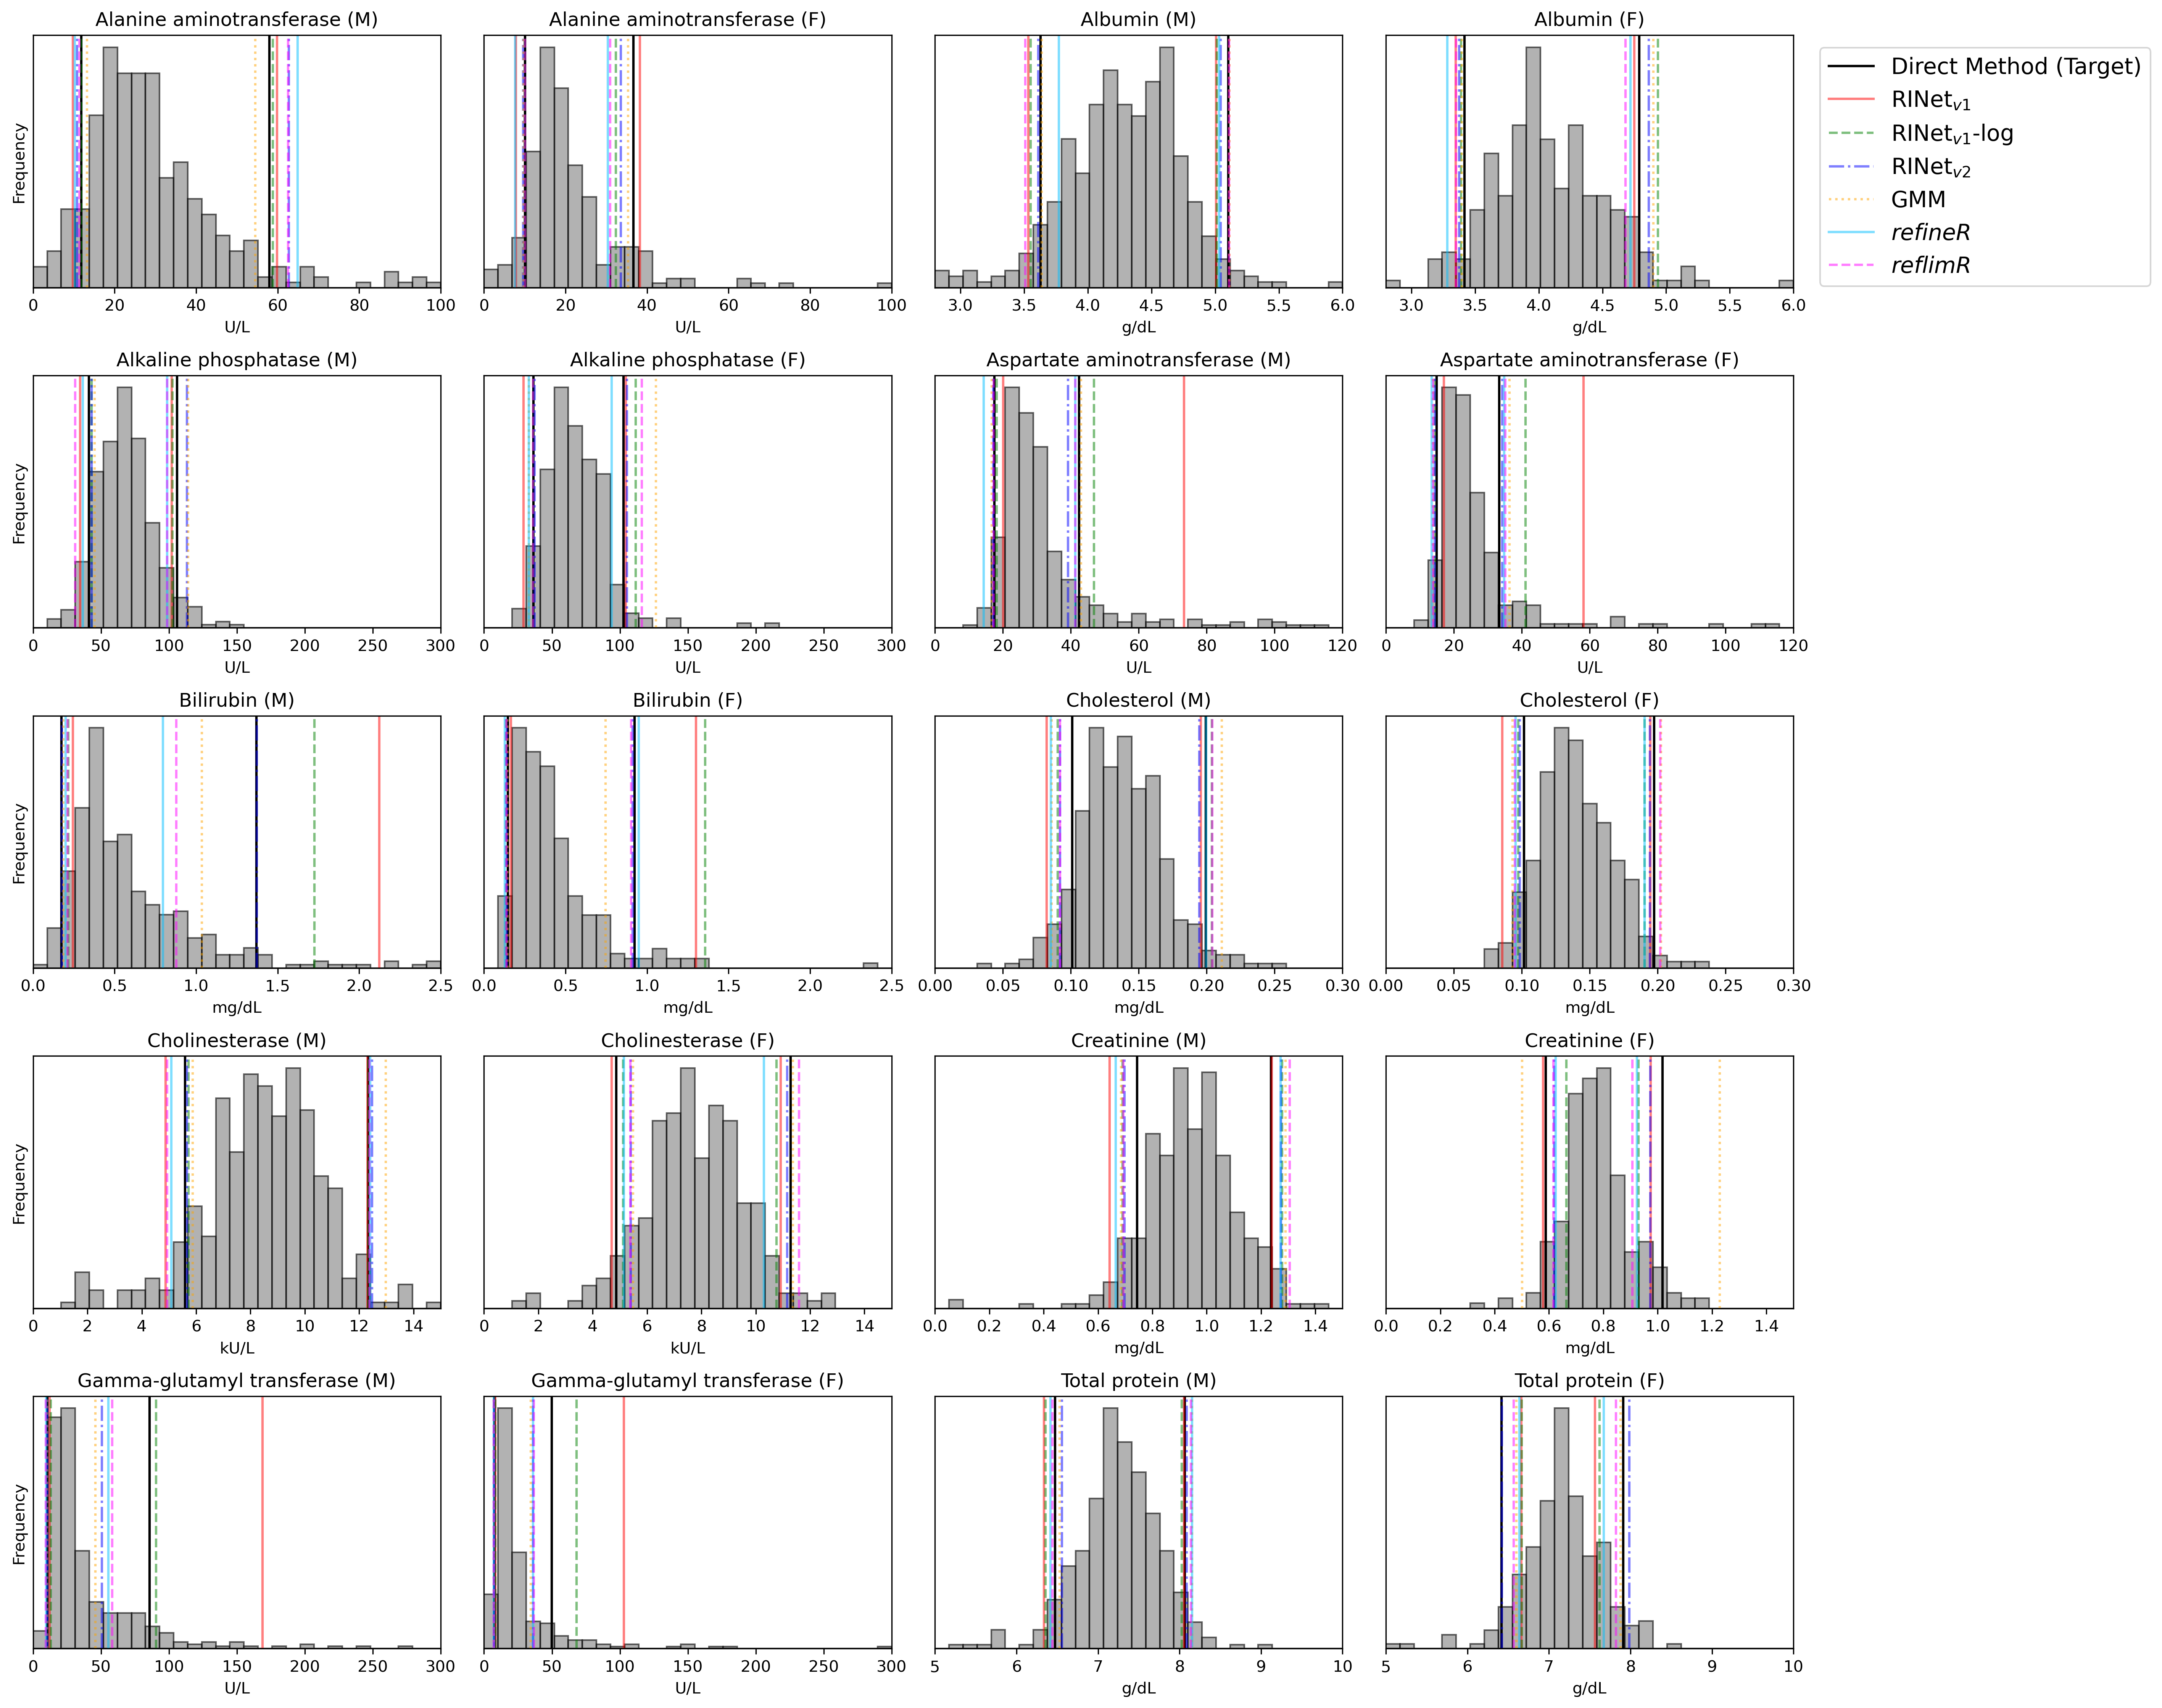

In [3]:
# grid layout

log_transform = False

n_samples = len(samples)
cols = 4
rows = (n_samples + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), dpi=300)
axes = axes.flatten()

colors = ['r', 'g', 'b', 'orange', 'deepskyblue', 'magenta']
linestyles = ['-', '--', '-.', ':']

for i, sample in enumerate(samples):
    ax = axes[i]

    # possible outlier removal
    # sample = sample[~lib.flag_outliers(sample.reshape(-1, 1))]

    analyte = metadata['analyte'].iloc[i]
    # histogram
    if log_transform:
        sample = np.log(sample)
    lims = limits[analyte]
    ax.hist(sample, bins=np.linspace(lims[0], lims[1], 30), alpha=0.6, color='gray', edgecolor='black')

    # target interval
    target_interval = targets[i]
    if log_transform:
        target_interval = np.log(target_interval)
    ax.axvline(target_interval[0], color='k', linestyle='-', label='Direct Method (Target)' if i==0 else "")
    ax.axvline(target_interval[1], color='k', linestyle='-')

    # prediction intervals
    for j, (model_name, model_preds) in enumerate(predictions.items()):
        interval = model_preds[i]
        if log_transform:
            interval = np.log(interval)
        color = colors[j % len(colors)]
        linestyle = linestyles[j % len(linestyles)]
        ax.axvline(interval[0], color=color, alpha=0.5, linestyle=linestyle, label=model_name_map[model_name] if i == 0 else "")
        ax.axvline(interval[1], color=color, alpha=0.5, linestyle=linestyle)

    ax.set_title(f"{analyte.capitalize()} ({metadata['gender'].iloc[i]})")
    ax.set_xlabel(units[analyte])
    ax.set_xlim(lims)
    ax.set_yticks([])
    if i % 4 == 0:
        ax.set_ylabel("Frequency")

# remove empty subplots if any
for j in range(n_samples, len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(handles, labels,
           loc="center left",
           bbox_to_anchor=(0.99, 0.90),  # adjust y for vertical centering
           fontsize=14)
plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=1.0)
plt.savefig('all_predictions.png', bbox_inches='tight')
plt.show()
